In [1]:
# imports and setup
%load_ext autoreload
%autoreload 2
%cd '/home/naodell/work/hgcal/analysis'

/home/naodell/work/hgcal/analysis


In [33]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn import preprocessing
import seaborn as sns
from tqdm.notebook import tqdm, trange

from utils.geometry_tools import conv_mask
from models.autoencoder import AutoEncoderWafer, Autoencoder
from models.loss import mse_loss_regularized
from datasets.hgcal_tc_dataset import HGCalTCModuleDataset

#%connect_info

In [34]:
# get the data
input_dir = 'local_data/econ_training_data/single_photon_data/'
input_filenames = [f'{input_dir}/{f}' for f in os.listdir(input_dir)]
hgcal_data = HGCalTCModuleDataset(input_filenames, do_stacks=False)

# sample from dataframe according to event weights; split into testing and training sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# training sample
batch_size = 8
n_total = len(hgcal_data)
split = round(0.8*n_total)
train_loader = DataLoader(hgcal_data[:split],  batch_size=batch_size, shuffle=True, pin_memory=True)

test_loader = DataLoader(hgcal_data[split:],  batch_size=batch_size, shuffle=True, pin_memory=True)

print(f'Total number of events: {n_total}')

Total number of events: 91816


In [35]:
# define and setup the NN model
n_flat_dimensions = np.product(hgcal_data[0].shape)
#model = AutoEncoderWafer(n_flat_dimensions, device).to(device)
model = AutoEncoderWafer().to(device)
print(device, model, sep='\n')

cuda
AutoEncoderWafer(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_enc): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_enc): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): ReLU()
  )
  (linear_dec): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
  )
  (tconv2d_dec): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
  )
)


In [37]:
# optimize NN weights
n_epochs = 10
n_events = len(train_loader)

# define loss and configure optimizer
loss_fn = nn.HuberLoss(reduction='sum')
#loss_fn = mse_loss_regularized

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
tb_writer = SummaryWriter(log_dir='logs')

pbar1 = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
pbar1.set_postfix({'avg. loss':'?'})
loss_cache = []
for iepoch in pbar1:
    model.train()
    pbar2 = tqdm(train_loader, total=n_events, leave=False, position=1)
    pbar2.set_postfix({'loss':'?'})
    avg_loss = 0
    for jevent, features in enumerate(pbar2):
        features = features.unsqueeze(1).to(device)
        #targets = targets.to(device)
        optimizer.zero_grad()
        features_pred = model(features)
        loss = loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
        loss.backward()
        optimizer.step()
        
        #pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
        #tb_writer.add_scalar('training loss', loss.item(), iepoch*n_events + jevent)
        
        avg_loss += loss.item()
        if jevent%1000 == 0:
            avg_loss /= 1000
            pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
            #tb_writer.add_scalar('training loss', avg_loss, iepoch*(n_events//1000) + jevent/1000)
            tb_writer.add_scalar('training loss', loss.item(), iepoch*(n_events//1000) + jevent/1000)
            avg_loss = 0
        
    with torch.no_grad():
        model.eval()
        test_loss = 0
        n_test_events = len(test_loader)
        for features in tqdm(test_loader, total=n_test_events, leave=False):
            features = features.unsqueeze(1).to(device)
            #targets = targets.to(device)
            features_pred = model(features)
            #print(features_pred.shape, features.shape)
            test_loss += loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
            loss_cache.append(test_loss.item())
            
            
        avg_loss = test_loss.item()/n_test_events
        pbar1.set_postfix({'avg loss':f'{avg_loss:.3f}'})
        tb_writer.add_scalar('test loss', avg_loss, iepoch)
        tb_writer.add_graph(model, features)
        
        #images = torchvision.utils.make_grid(features)
        #images_pred = torchvision.utils.make_grid(features_pred)
        #tb_writer.add_image('input', images)
        #tb_writer.add_image('output', images_pred)
        
        # write a checkpoint based on the performance of the model



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9182 [00:00<?, ?it/s]

AttributeError: 'AutoEncoderWafer' object has no attribute 'weight_update_mask'

IndexError: index 4 is out of bounds for axis 0 with size 4

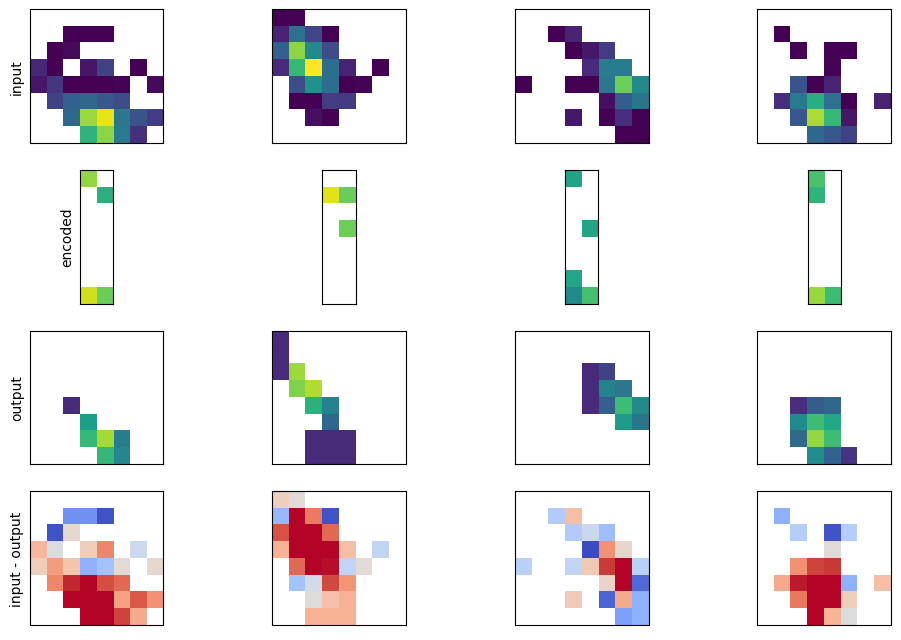

In [6]:
# compare images
from matplotlib.colors import LogNorm

with torch.no_grad():
    model.eval()
    
    fig, axes = plt.subplots(4, 4, facecolor='white', figsize=(12, 8), sharey=False, sharex=False)
    images = iter(test_loader).next()
    images = images.unsqueeze(1).to(device)
    images_pred = model(images)
    encoded_images = model.encode(images)
    for ix, (image, encoded_image, image_pred) in enumerate(zip(images, encoded_images, images_pred)):
        image = image.squeeze().cpu().numpy()
        encoded_image = encoded_image.squeeze().cpu().numpy()
        image_pred = image_pred.squeeze().cpu().numpy().reshape(image.shape)
        
        ax = axes[0][ix]
        ax.imshow(image, norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('input')
        
        ax = axes[1][ix]
        ax.imshow(encoded_image.reshape(-1, 2), norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('encoded')
            
        ax = axes[2][ix]
        ax.imshow(image_pred, norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('output')
        
        ax = axes[3][ix]
        ax.imshow(abs(image - image_pred), norm=LogNorm(vmin=0.01, vmax=1), cmap='coolwarm')
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('input - output')
            
        #plt.colorbar()
        
        if ix == 9: break

    plt.tight_layout()
    plt.show()

  0%|          | 0/1677 [00:00<?, ?it/s]

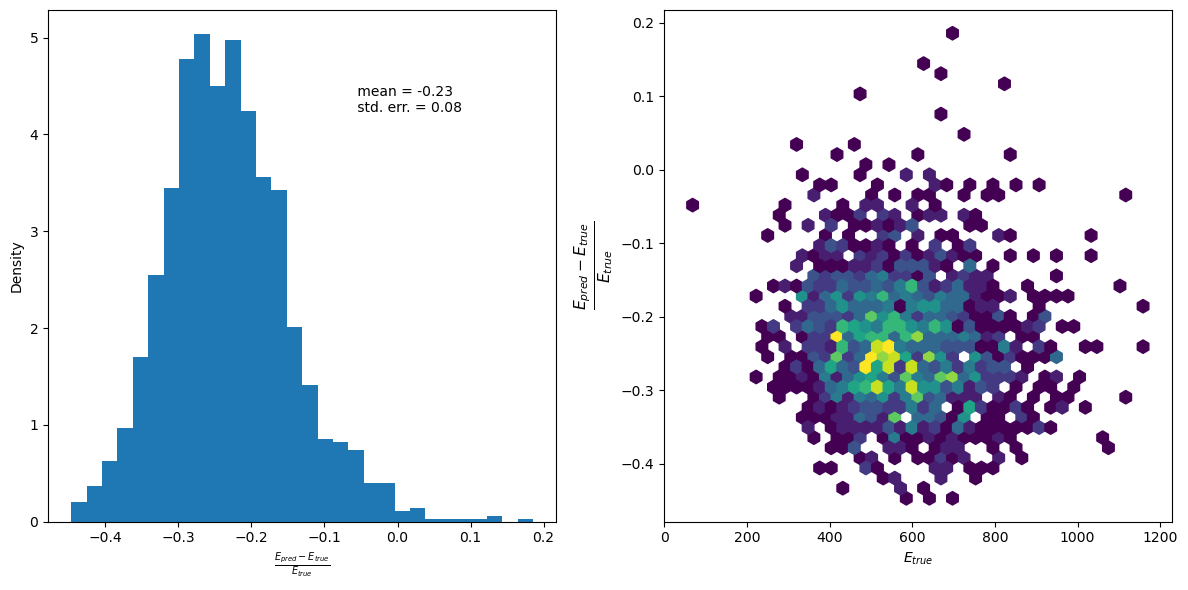

In [7]:
# Plot the the total error for both total energy and 
energy_diff = []
energy_sums = []
with torch.no_grad():
    model.eval()
    test_loss = 0
    n_test_events = len(test_loader)
    for features in tqdm(test_loader, total=n_test_events, leave=False):
        features = features.unsqueeze(1).to(device)
        #targets = targets.to(device)
        features_pred = model(features)
        diff = features_pred.sum() - features.sum()
        energy_diff.append(diff.item())
        energy_sums.append(features.sum().item())
        #print(features_pred.shape, features.shape)
        test_loss += loss_fn(torch.log(1. + features_pred), torch.log(1. + features))

energy_diff = np.array(energy_diff)
energy_sums = np.array(energy_sums)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
frac_energy_diff = energy_diff/energy_sums
ax.hist(frac_energy_diff, bins=30, density=True)
ax.set_xlabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$')
ax.set_ylabel('Density')
ax.text(0.6, 0.8, f' mean = {frac_energy_diff.mean():.2f} \n std. err. = {frac_energy_diff.std():.2f}', transform=ax.transAxes)

ax = axes[1]
ax.hexbin(energy_sums, frac_energy_diff, gridsize=40, mincnt=1)
ax.set_ylabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$', size=16)
ax.set_xlabel(r'$E_{true}$')


plt.tight_layout()
plt.show()